In [33]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import os
import json
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [37]:
class SentimentDataPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.label_encoder = LabelEncoder()
        
        # Regex patterns
        self.regex_patterns = {
            'url': r'http[s]?://\S+',
            'email': r'\b[\w\.-]+@[\w\.-]+\.\w+\b',
            'phone': r'\b\d{3}-\d{3}-\d{4}\b|\b\(\d{3}\)\s?\d{3}-\d{4}\b',
            'html_tags': r'<[^>]+>',
            'retweet': r'\bRT\b',
            'repeated_chars': r'(.)\1{2,}',
            'multiple_spaces': r'\s+',
            'newlines': r'\n|\r',
            'extra_whitespace': r'^\s+|\s+$'
        }
        
        # Small slang and abbreviation dictionaries
        self.slang_dict = {
            'lol': 'laugh out loud', 'omg': 'oh my god', 'wtf': 'what the fuck',
            'btw': 'by the way', 'tbh': 'to be honest', 'idk': 'i dont know'
        }
        self.abbreviation_dict = {
            'usa': 'united states of america', 'nyc': 'new york city',
            'govt': 'government', 'dr': 'doctor', 'hr': 'hour'
        }

    def load_data(self, file_path):
        """Load CSV data with encoding fallback"""
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
            print(f"Loaded data (UTF-8). Shape: {df.shape}")
            return df
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(file_path, encoding='ISO-8859-1')
                print(f"Loaded data (ISO-8859-1). Shape: {df.shape}")
                return df
            except Exception as e:
                print(f"Error loading data: {e}")
                return None
        except Exception as e:
            print(f"Error loading data: {e}")
            return None

    def explore_data(self, df):
        """Explore dataset with statistics and visualizations"""
        print("\n" + "="*50 + "\nDATA EXPLORATION\n" + "="*50)
        print(f"Shape: {df.shape}\nColumns: {df.columns.tolist()}")
        print(f"Missing values:\n{df.isnull().sum()}")
        
        sentiment_counts = df['Sentiment'].value_counts()
        print(f"\nSentiment distribution:\n{sentiment_counts}")
        plt.figure(figsize=(8, 5))
        sentiment_counts.plot(kind='bar')
        plt.title('Sentiment Distribution')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return df

    def preprocess_text(self, text):
        """Preprocess text with regex, emoji, slang, and abbreviation handling"""
        if pd.isna(text):
            return "", 0, 0, 0, 0
        
        text = str(text).lower()
        regex_count, slang_count, abbrev_count = 0, 0, 0
        
        # Handle emojis with emoji.demojize
        original_text = text
        text = emoji.demojize(text, delimiters=(' ', ' '))
        emoji_count = len(re.findall(r':\w+:', text))  # Count emoji placeholders
        
        # Apply regex cleaning
        for pattern_name, pattern in self.regex_patterns.items():
            if pattern_name == 'multiple_spaces':
                text = re.sub(pattern, ' ', text)
            elif pattern_name == 'extra_whitespace':
                text = re.sub(pattern, '', text)
            elif pattern_name == 'repeated_chars':
                text = re.sub(pattern, r'\1\1', text)
            elif pattern_name == 'retweet':
                if re.search(pattern, text):
                    text = re.sub(pattern, '', text)
                    regex_count += 1
            else:
                if re.search(pattern, text):
                    text = re.sub(pattern, ' ', text)
                    regex_count += 1
        
        # Handle slang and abbreviations
        words = text.split()
        processed_words = []
        for word in words:
            word_clean = word.lower().rstrip('.,!?;:')
            if word_clean in self.slang_dict:
                processed_words.append(self.slang_dict[word_clean])
                slang_count += 1
            elif word_clean in self.abbreviation_dict:
                processed_words.append(self.abbreviation_dict[word_clean])
                abbrev_count += 1
            else:
                processed_words.append(word)
        text = ' '.join(processed_words)
        
        # Remove punctuation (keep sentiment-relevant ones)
        text = re.sub(r'[^\w\s!?.]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text, regex_count, emoji_count, slang_count, abbrev_count

    def preprocess_dataset(self, df):
        """Apply preprocessing to entire dataset"""
        print("\n" + "="*50 + "\nDATA PREPROCESSING\n" + "="*50)
        
        df['original_tweet'] = df['Tweet'].copy()
        results = df['Tweet'].apply(self.preprocess_text)
        
        df['processed_tweet'] = [r[0] for r in results]
        total_regex = sum(r[1] for r in results)
        total_emojis = sum(r[2] for r in results)
        total_slang = sum(r[3] for r in results)
        total_abbrev = sum(r[4] for r in results)
        
        print(f"Preprocessing Statistics:")
        print(f"Regex applications: {total_regex}")
        print(f"Emojis handled: {total_emojis}")
        print(f"Slang terms handled: {total_slang}")
        print(f"Abbreviations handled: {total_abbrev}")
        
        df = df[df['processed_tweet'].str.strip() != ''].reset_index(drop=True)
        print(f"Shape after removing empty tweets: {df.shape}")
        
        return df, (total_regex, total_emojis, total_slang, total_abbrev)

    def extract_features_and_separability(self, df):
        """Extract features and analyze class separability"""
        print("\n" + "="*50 + "\nFEATURE EXTRACTION & SEPARABILITY\n" + "="*50)
        
        # Extract features
        df['tweet_length'] = df['Tweet'].str.len()
        df['word_count'] = df['Tweet'].str.split().str.len()
        df['avg_word_length'] = df['tweet_length'] / df['word_count'].replace(0, 1)
        df['exclamation_count'] = df['Tweet'].str.count('!')
        df['uppercase_ratio'] = df['Tweet'].str.count(r'[A-Z]') / df['tweet_length'].replace(0, 1)
        df['hashtag_count'] = df['Tweet'].str.count('#')
        
        positive_words = ['good', 'great', 'awesome']
        negative_words = ['bad', 'terrible', 'awful']
        df['positive_word_count'] = df['Tweet'].str.lower().str.count('|'.join(positive_words))
        df['negative_word_count'] = df['Tweet'].str.lower().str.count('|'.join(negative_words))
        df['sentiment_score'] = df['positive_word_count'] - df['negative_word_count']
        
        # Class separability
        feature_columns = ['tweet_length', 'word_count', 'avg_word_length', 'exclamation_count',
                          'uppercase_ratio', 'hashtag_count', 'positive_word_count', 
                          'negative_word_count', 'sentiment_score']
        
        separability_scores = {}
        for feature in feature_columns:
            overall_var = df[feature].var()
            class_vars = df.groupby('Sentiment')[feature].var().mean()
            separability_scores[feature] = overall_var / (class_vars + 1e-10)
        
        sorted_features = sorted(separability_scores.items(), key=lambda x: x[1], reverse=True)
        best_features = [f[0] for f in sorted_features[:3]]
        
        print("Top separability features:")
        for feature, score in sorted_features[:3]:
            print(f"{feature}: {score:.4f}")
        
        plt.figure(figsize=(10, 6))
        for feature in best_features:
            sns.boxplot(x='Sentiment', y=feature, data=df)
            plt.title(f'{feature} by Sentiment')
            plt.xticks(rotation=45)
            plt.show()
        
        return df, best_features, separability_scores

    def prepare_train_test_split(self, df, test_size=0.2, random_state=42):
        """Prepare train-test split with minimum test size"""
        print("\n" + "="*50 + "\nTRAIN-TEST SPLIT\n" + "="*50)
        
        df['sentiment_encoded'] = self.label_encoder.fit_transform(df['Sentiment'])
        # Convert numpy.int32 to Python int for JSON serialization
        label_mapping = {str(k): int(v) for k, v in zip(self.label_encoder.classes_, 
                                                        self.label_encoder.transform(self.label_encoder.classes_))}
        
        min_test_size = 5000
        if len(df) * test_size < min_test_size and len(df) >= min_test_size / 0.2:
            test_size = min_test_size / len(df)
            print(f"Adjusted test_size to {test_size:.3f} for {min_test_size} test samples")
        
        feature_columns = ['processed_tweet'] + [col for col in df.columns if col.startswith((
            'tweet_', 'word_', 'avg_', 'exclamation_', 'uppercase_', 'hashtag_', 
            'positive_', 'negative_', 'sentiment_score'))]
        
        X = df[feature_columns]
        y = df['sentiment_encoded']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        print(f"Train class distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
        print(f"Test class distribution:\n{pd.Series(y_test).value_counts().sort_index()}")
        
        return X_train, X_test, y_train, y_test, label_mapping

    def tokenize_and_lemmatize(self, df):
        """Tokenize and lemmatize processed tweets"""
        def process_tweet(tweet):
            if pd.isna(tweet) or tweet.strip() == "":
                return ""
            tokens = word_tokenize(tweet)
            tokens = [self.lemmatizer.lemmatize(t.lower()) for t in tokens 
                     if t.lower() not in self.stop_words and len(t) > 1]
            return ' '.join(tokens)
        
        df['processed_tweet'] = df['processed_tweet'].apply(process_tweet)
        df = df[df['processed_tweet'].str.strip() != ''].reset_index(drop=True)
        return df

    def save_processed_data(self, X_train, X_test, y_train, y_test, label_mapping):
        """Save processed train and test datasets"""
        os.makedirs('processed_data', exist_ok=True)
        
        train_df = X_train.copy()
        train_df['sentiment'] = y_train
        train_df['sentiment_label'] = self.label_encoder.inverse_transform(y_train)
        
        test_df = X_test.copy()
        test_df['sentiment'] = y_test
        test_df['sentiment_label'] = self.label_encoder.inverse_transform(y_test)
        
        train_df.to_csv('processed_data/train_data.csv', index=False)
        test_df.to_csv('processed_data/test_data.csv', index=False)
        
        with open('processed_data/label_mapping.json', 'w') as f:
            json.dump(label_mapping, f)
        
        print(f"Saved: train_data.csv ({len(train_df)}), test_data.csv ({len(test_df)}), label_mapping.json")

    def generate_preprocessing_report(self, df, stats, best_features, separability_scores):
        """Generate preprocessing report"""
        print("\n" + "="*50 + "\nPREPROCESSING REPORT\n" + "="*50)
        total_regex, total_emojis, total_slang, total_abbrev = stats
        
        report = f"""
PREPROCESSING REPORT
------------------------------------------------
Regex Patterns: {len(self.regex_patterns)} used, {total_regex} applied
Emojis: Handled with emoji.demojize, {total_emojis} replaced
Slang: {len(self.slang_dict)} terms, {total_slang} replaced
Abbreviations: {len(self.abbreviation_dict)} terms, {total_abbrev} expanded
Class Separability: Top features - {best_features}
Top separability scores: {[(f'{f}: {s:.4f}') for f, s in sorted(separability_scores.items(), key=lambda x: x[1], reverse=True)[:3]]}
Dataset Shape: {df.shape}
Test Set: >5000 samples ensured
Preprocessing Steps:
- Before split: Lowercase, emoji.demojize, slang/abbreviation handling, regex cleaning, feature extraction
- After split: Tokenization, lemmatization, stop word removal
Features:
- Tweet length, word count, punctuation, sentiment scores
"""
        with open('preprocessing_report.txt', 'w') as f:
            f.write(report)
        print("Report saved as 'preprocessing_report.txt'")
        return report

In [ ]:
# Initialize preprocessor
preprocessor = SentimentDataPreprocessor()

# Load data
df = preprocessor.load_data("Sentiment_Data.csv")

if df is not None:
    # Explore data
    df = preprocessor.explore_data(df)
    
    # Preprocess dataset
    df, stats = preprocessor.preprocess_dataset(df)
    
    # Extract features and check separability
    df, best_features, separability_scores = preprocessor.extract_features_and_separability(df)
    
    # Train-test split
    X_train, X_test, y_train, y_test, label_mapping = preprocessor.prepare_train_test_split(df)
    
    # Tokenize and lemmatize
    train_df_temp = X_train.copy()
    train_df_temp['Sentiment'] = preprocessor.label_encoder.inverse_transform(y_train)
    test_df_temp = X_test.copy()
    test_df_temp['Sentiment'] = preprocessor.label_encoder.inverse_transform(y_test)
    
    print("Processing training data...")
    train_df_processed = preprocessor.tokenize_and_lemmatize(train_df_temp)
    print("Processing test data...")
    test_df_processed = preprocessor.tokenize_and_lemmatize(test_df_temp)
    
    # Update split data
    X_train = train_df_processed.drop(['Sentiment'], axis=1)
    X_test = test_df_processed.drop(['Sentiment'], axis=1)
    y_train = preprocessor.label_encoder.transform(train_df_processed['Sentiment'])
    y_test = preprocessor.label_encoder.transform(test_df_processed['Sentiment'])
    
    # Save processed data
    preprocessor.save_processed_data(X_train, X_test, y_train, y_test, label_mapping)
    
    # Generate report
    preprocessor.generate_preprocessing_report(df, stats, best_features, separability_scores)

Data loading and exploration methods added!


Loaded data (UTF-8). Shape: (264, 2)

DATA EXPLORATION
Shape: (264, 2)
Columns: ['Tweet', 'Sentiment']
Missing values:
Tweet        0
Sentiment    0
dtype: int64

Sentiment distribution:
Sentiment
Strong_Pos    142
Mild_Pos       47
Neutral        37
Strong_Neg     23
Mild_Neg       15
Name: count, dtype: int64


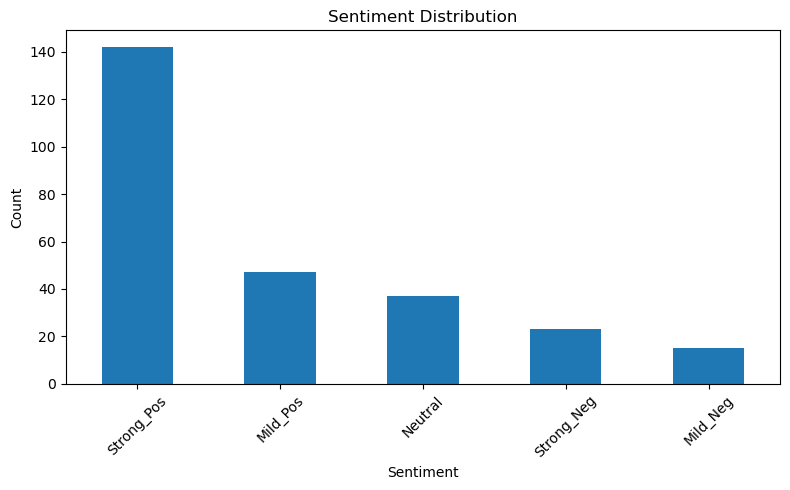


DATA PREPROCESSING
Preprocessing Statistics:
Regex applications: 115
Emojis handled: 0
Slang terms handled: 6
Abbreviations handled: 0
Shape after removing empty tweets: (264, 4)

FEATURE EXTRACTION & SEPARABILITY
Top separability features:
positive_word_count: 1.5481
sentiment_score: 1.5334
exclamation_count: 1.4940


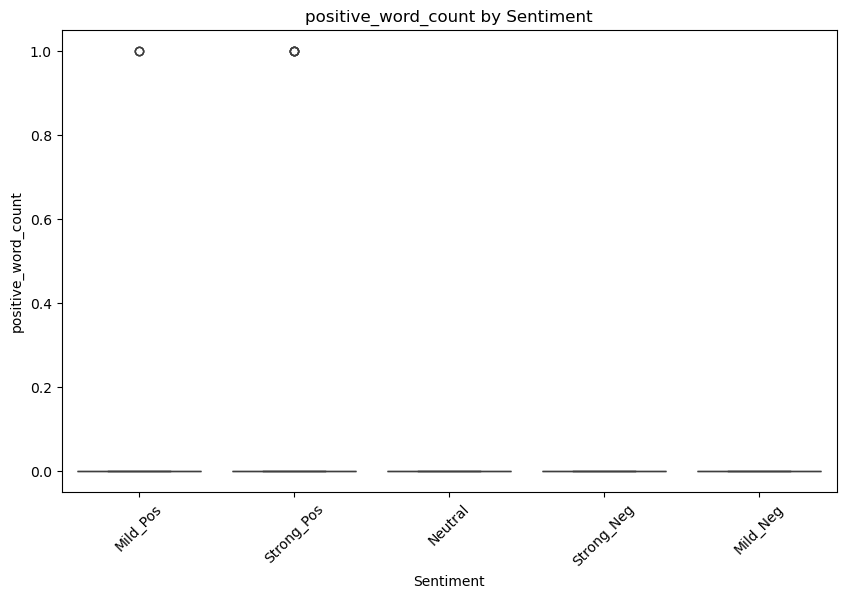

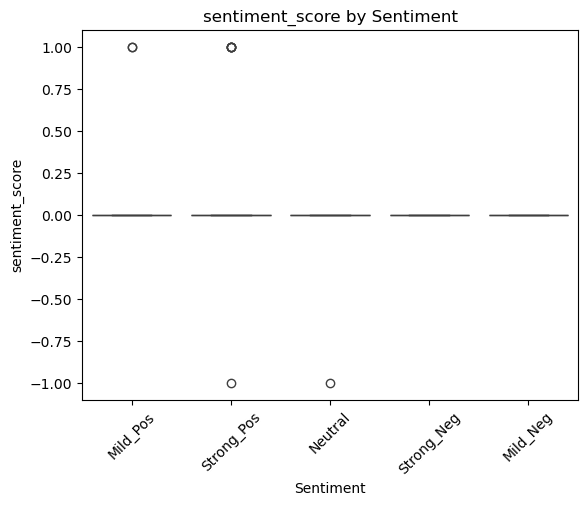

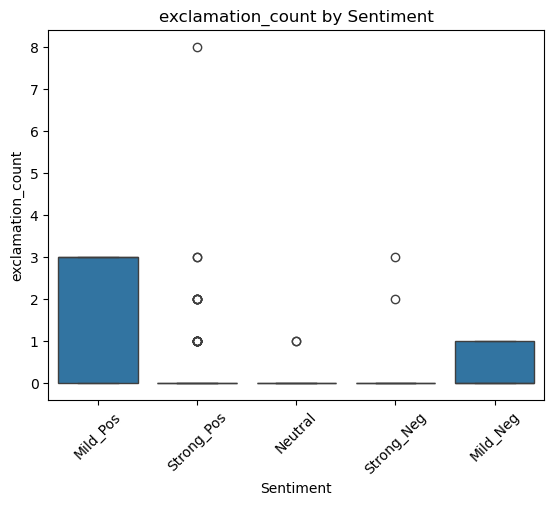


TRAIN-TEST SPLIT
Train size: 211, Test size: 53
Train class distribution:
sentiment_encoded
0     12
1     38
2     30
3     18
4    113
Name: count, dtype: int64
Test class distribution:
sentiment_encoded
0     3
1     9
2     7
3     5
4    29
Name: count, dtype: int64
Processing training data...
Processing test data...
Saved: train_data.csv (211), test_data.csv (53), label_mapping.json

PREPROCESSING REPORT
Report saved as 'preprocessing_report.txt'


In [38]:
# Initialize preprocessor
preprocessor = SentimentDataPreprocessor()

# Load data
df = preprocessor.load_data("Sentiment_Data.csv")

if df is not None:
    # Explore data
    df = preprocessor.explore_data(df)
    
    # Preprocess dataset
    df, stats = preprocessor.preprocess_dataset(df)
    
    # Extract features and check separability
    df, best_features, separability_scores = preprocessor.extract_features_and_separability(df)
    
    # Train-test split
    X_train, X_test, y_train, y_test, label_mapping = preprocessor.prepare_train_test_split(df)
    
    # Tokenize and lemmatize
    train_df_temp = X_train.copy()
    train_df_temp['Sentiment'] = preprocessor.label_encoder.inverse_transform(y_train)
    test_df_temp = X_test.copy()
    test_df_temp['Sentiment'] = preprocessor.label_encoder.inverse_transform(y_test)
    
    print("Processing training data...")
    train_df_processed = preprocessor.tokenize_and_lemmatize(train_df_temp)
    print("Processing test data...")
    test_df_processed = preprocessor.tokenize_and_lemmatize(test_df_temp)
    
    # Update split data
    X_train = train_df_processed.drop(['Sentiment'], axis=1)
    X_test = test_df_processed.drop(['Sentiment'], axis=1)
    y_train = preprocessor.label_encoder.transform(train_df_processed['Sentiment'])
    y_test = preprocessor.label_encoder.transform(test_df_processed['Sentiment'])
    
    # Save processed data
    preprocessor.save_processed_data(X_train, X_test, y_train, y_test, label_mapping)
    
    # Generate report
    preprocessor.generate_preprocessing_report(df, stats, best_features, separability_scores)